In [22]:
import numpy as np
import pandas as pd
import random
import itertools
import math
from math import sqrt, exp, log, floor
from functools import partial
import matplotlib.pyplot as plt
from statistics import mean
%matplotlib inline
np.seterr(all = 'raise')
infinity = 1e2

In [23]:
def standardize(data):
    d_mean = np.mean(data)
    d_stddev = np.std(data, ddof=1)
    if d_stddev == 0:
        return data
    return np.array([ (d-d_mean)/d_stddev for d in data ])

In [24]:
# Batch Gradient Descent

def data_converged(theta_prime, theta, p, tol):
    try:
        return sqrt(sum([ (theta_prime[i] - theta[i])**2 for i in range(p) ])) < tol
    except FloatingPointError:
        # treat numerical overflow as convergence
        return True

# dJ: gradient of J
# alpha: learning rate
# tol: tolerance
# init_theta: vector of inital values for theta
# max_num_rounds: max iterations of the algorithm
# x_data: x data points
# y_data: y data points
def batch_gradient_descent(dJ, alpha, tol, init_theta, max_num_rounds, x_data, y_data):
    p = len(dJ)
    assert(p == len(init_theta))
    assert(p == np.array(x_data).shape[1])
    assert(len(x_data) == len(y_data))
    
    theta = init_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = [theta[i] - alpha * dJ[i](theta, x_data, y_data) for i in range(p)]
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
            
    return theta

In [25]:
# example for using lasso with batch GD

def dotp(x1, x2):
    return sum([x1i*x2i for (x1i,x2i) in zip(x1,x2)])

def dtheta_di_lasso(lam, i, theta, x_data, y_data):
    accum = 0.0
    for (xj,yj) in zip(x_data,y_data):
        xji = xj[i]
        accum += -2 * xji * (yj - dotp(theta,xj)) + lam*abs(theta[i])/theta[i]
    return accum

def lasso_batch_gd(lam, x_data, y_data):
    p = np.array(x_data).shape[1]
    alpha = 0.0001
    tol = 0.0001
    init_theta = np.array([0.1 for _ in range(p)])
    #init_theta = np.linalg.lstsq(x_data,y_data,rcond=None)[0]
    #init_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 100
    dJ = [ partial(dtheta_di_lasso, lam, i) for i in range(p) ]
    return batch_gradient_descent(dJ, alpha, tol, init_theta, max_num_rounds, x_data, y_data)

In [26]:
# Pathwise Coordinate Descent

def nej(j, e, k):
    return 0 if k == j else e

def sum_nej(xi, theta, j):
    return sum([ nej(j, xi[k]*theta[k], k) for k in range(len(theta)) ])

def soft_thresh(a):
    return max(a, 0)

def sign(a):
    # we can define sign(0) = 1 without any harm here because of the assert on lam in S
    return 1 if a >= 0 else -1
    
def S(t, B):
    assert(B >= 0)
    return sign(t)*soft_thresh(abs(t) - B)

def diverged(theta):
    too_large = 1e20
    return sqrt(sum([ theta_i**2 for theta_i in theta ])) > too_large

# A template for Pathwise CD.  A and B are parameters that depend on the objective function
# we wish to maximize
def pathwise_cd(A, B, x_data, y_data):
    assert(A >= 0)
    assert(B >= 0)
    assert(len(x_data.shape) == 2) # x_data must be 2D
    assert(len(y_data.shape) == 1) # y_data must be 1D
    N = x_data.shape[0]
    p = x_data.shape[1]
    assert(N >= 2)
    assert(N == y_data.shape[0])
    
    initial_theta = np.array([0. for _ in range(p)])
    #initial_theta = np.linalg.lstsq(x_data,y_data,rcond=None)[0]
    #initial_theta = np.dot( np.linalg.inv(np.dot(x_data.T,x_data) + lam*np.identity(p)), np.dot(x_data.T,y_data) )
    max_num_rounds = 1000
    tol = 0.0001
    
    theta = initial_theta
    converged = False
    num_rounds = 0
    while not converged and num_rounds < max_num_rounds:
        num_rounds = num_rounds + 1
        theta_prime = theta.copy()
        for j in range(p):
            theta_prime[j] = S( sum([ xi[j]*(yi - sum_nej(xi,theta_prime,j))
                                        for (xi,yi) in zip(x_data,y_data) ]) / A,
                                B)
        converged = data_converged(theta_prime, theta, p, tol)
        theta = theta_prime
    
    return theta

In [27]:
# pathwise CD implementations depending on the objective function we wish to maximize

def lasso_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    return pathwise_cd(N-1, lam, x_data, y_data)

def elastic_net_pathwise_cd(alpha, lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam*alpha
    B = lam*(1-alpha)
    return pathwise_cd(A, B, x_data, y_data)

def ridge_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam
    B = 0
    return pathwise_cd(A, B, x_data, y_data)

def ridge_st_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam
    B = lam
    return pathwise_cd(A, B, x_data, y_data)

def ridge_st_quad_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam
    B = lam**2
    return pathwise_cd(A, B, x_data, y_data)

def ridge_st_exp_pathwise_cd(lam, x_data, y_data):
    N = y_data.shape[0]
    A = (N-1) + 2*lam
    B = math.exp(lam) - 1
    return pathwise_cd(A, B, x_data, y_data)

In [28]:
################################################################################################
############### Everything below is testing for the various algorithms above ###################
################################################################################################

In [29]:
# data generation

def unif_simulation(a, b, N=1):
    return np.random.uniform(a, b, N)

def normal_simulation(mean, stddev, N):
    return np.random.normal(mean, stddev, N)

def e():
    return normal_simulation(0, np.sqrt(4), 1)[0]
    
def e_err():
    if unif_simulation(1,100) <= 10:
        if unif_simulation(1,2) == 1:
            return normal_simulation(0, np.sqrt(4), 1)[0] + 5
        else:
            return normal_simulation(0, np.sqrt(4), 1)[0] - 5
    else:
        return normal_simulation(0, np.sqrt(4), 1)[0]

def Y(f, x):
    return f(x) + e()

# creates a (n x p) design matrix
def create_design_mat(x_data, max_order):
    data = []
    for order in range(max_order + 1):
        data.append(standardize([d ** order for d in x_data]))
    return np.array(data).T

def calc_yhat(theta, x):
    max_order = len(theta)
    xvals = [x ** order for order in range(max_order+1)]
    return sum([theta_i*x_i for (theta_i,x_i) in zip(theta,xvals)])

In [30]:
def mse(y, y_hat):
    n = y.shape[0]
    assert(n == y_hat.shape[0])
    assert(len(y.shape) == 1)
    assert(len(y_hat.shape) == 1)
    try:
        return sum([ (yi-yi_hat)**2 for (yi,yi_hat) in zip(y,y_hat) ]) / n
    except FloatingPointError:
        return infinity

def validate(y_data, design, model):
    y_hats = np.array([ model @ xi for xi in design ])
    return mse(y_data, y_hats)

def test(algo, lam, f, p):
    N = 50
    M = 5000
    width = 100
    
    x_data_train = unif_simulation(-width, width, N)
    y_data_train = standardize([Y(f, x) for x in x_data_train])
    design_train = create_design_mat(x_data_train, p)
    model = algo(lam, design_train, y_data_train)
    print(model)
    
    x_data_valid = unif_simulation(-width, width, M)
    y_data_valid = standardize([Y(f, x) for x in x_data_valid])
    design_valid = create_design_mat(x_data_valid, p)
    mse = validate(y_data_valid, design_valid, model)
    return mse

In [31]:
# K-fold cross validation

def randomly_shuffle(x_data, y_data):
    xd = list(x_data.copy())
    yd = list(y_data.copy())
    x_shuff = []
    y_shuff = []
    while len(yd) > 0:
        idx = random.randrange(0, len(yd))
        x_shuff.append(xd.pop(idx))
        y_shuff.append(yd.pop(idx))
    return np.array(x_shuff), np.array(y_shuff)

def partition_data(k, x_data, y_data):
    N = len(y_data)
    sz = int(N/k)
    partitions = []
    for _ in range(int(k)):
        xd = x_data[0:sz]
        yd = y_data[0:sz]
        partitions.append((xd,yd))
        x_data = x_data[sz:None]
        y_data = y_data[sz:None]
    assert(x_data.shape[0] == 0)
    assert(y_data.shape[0] == 0)
    return partitions

def create_folds(partitions):
    folds = []
    for i in range(len(partitions)):
        xs = []
        ys = []
        for j in range(len(partitions)):
            if j != i:
                xs.extend(partitions[j][0])
                ys.extend(partitions[j][1])
        folds.append((np.array(xs),np.array(ys)))
    return folds

def k_cross_validation(k, algo, lam, x_data, y_data):
    N = len(y_data)
    assert(N % k == 0) # for uniform group sizes
    x_data, y_data = randomly_shuffle(x_data, y_data)
    partitions = partition_data(k, x_data, y_data)
    folds = create_folds(partitions)
    theta_hats = [algo(lam, xd, yd) for xd,yd in folds]
    assert(len(partitions) == k)
    assert(len(folds) == k)
    assert(len(theta_hats) == k)
    
    # individual partitions are used for validation error
    errors = [validate(yd,xd,theta_hat) for (xd, yd), theta_hat in zip(partitions, theta_hats)]
    return sum(errors) / k

def k_cross_validation_2arg(k, algo, alpha, lam, x_data, y_data):
    return k_cross_validation(k, partial(algo, alpha), lam, x_data, y_data)

def cv_plot(plot, errors, lams, desc, xlbl='lambda'):
    min_idx = np.argmin(errors)
    plot.plot(lams, errors, color='b')
    plot.axvline(x=lams[min_idx], color='r')
    #plot.ylim(bottom=-0.5, top=2)
    plot.xlabel(xlbl)
    plot.ylabel('MSE')
    plot.title(desc + ' - CV training error')
    #plot.show()

In [32]:
def gen_data_1D(f, N):
    width = 2
    x_data = unif_simulation(-width, width, N)
    x_data = x_data.reshape((N,1))
    y_data = standardize([Y(f, x[0]) for x in x_data])
    return x_data, y_data

def tuning_param_range(a, b, N, c=0):
    return [ c + a + (b-a)*i/N for i in range(N) ]

In [33]:
################################################################################################
########################### Training and Testing for each algorithm ############################
################################################################################################

In [34]:
f = lambda x: -2*x + x**2
N = 20
x_data, y_data = gen_data_1D(f, N)

In [35]:
def read_data(fname):
    data = pd.read_csv(fname)
    x_data = np.array([ row[0:-1] for row in data.values])
    y_data = np.array([ row[-1] for row in data.values])
    return x_data, y_data, data.columns

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
def month_indicator(i, month):
    midx = np.where(months == month)
    return 1 if i == midx else 0

def data_design_mat(data):
    design = []
    for row in data:
        numerical = row[0:-1]
        month = row[-1]
        drow = list(numerical)
        for i in range(12):
            drow.append(month_indicator(i, month))
        design.append(standardize(drow))
    return np.array(design)

In [36]:
# testing

colors = ['blue', 'green', 'brown', 'purple', 'yellow', 'lawngreen', 'darkblue', 'olive', 'greenyellow', 'silver']
def plot_lams(plot, errors, algo, lams, x_data, y_data, desc, xlbl='lambda'):
    min_idx = np.argmin(errors)
    plot.axvline(x=lams[min_idx], color='r')
    thetas = []
    for lam in lams:
        thetas.append(algo(lam, x_data, y_data))
    for p in range(len(thetas[0])):
        theta_is = [theta[p] for theta in thetas]
        plot.plot(lams, theta_is, color=colors[p%len(colors)], label=p)
    #plot.ylim(bottom=-0.5, top=2)
    plot.xlabel(xlbl)
    plot.ylabel('theta_i')
    plot.title(desc + ': theta v. ' + xlbl)

def test_algo(algo, x_data, y_data, lams, desc):
    design = data_design_mat(x_data)
    k = 5
    errors = [k_cross_validation(k, algo, lam, design, y_data) for lam in lams]
    min_idx = np.argmin(errors)
    best_lam = lams[min_idx]
    best_error = errors[min_idx]
    
    print("{} CV error: {} (lam={})".format(desc,best_error,best_lam))
    cv_plot(plt, errors, lams, desc)
    plt.show()
    plot_lams(plt, errors, algo, lams, design, y_data, desc)
    plt.show()
    return best_lam

def test_algo_file(algo, training_file, test_file, lams, desc):
    # CV to figure out the best lambda value
    x_data, y_data, cols = read_data(training_file)
    best_lam = test_algo(algo, x_data, y_data, lams, desc)
    design = data_design_mat(x_data)
    theta_hat = algo(best_lam, design, y_data)
    params = list(filter(lambda i: theta_hat[i] != 0, range(len(theta_hat))))
    print("params selected: {}".format(params))
    #print("theta_hat: {}".format(theta_hat))

    # determine the test error
    test_x_data, test_y_data, _ = read_data(test_file)
    test_design = data_design_mat(test_x_data)
    test_err = validate(test_y_data, test_design, theta_hat)
    print("test error: {}".format(test_err))

def test_fn_lt(algo, lams, folder):
    test = "data/{}/test.csv".format(folder)
    n_lt_p = "data/{}/n_lt_p.csv".format(folder)
    test_algo_file(algo, n_lt_p, test, lams, 'n<p')

def test_fn_eq(algo, lams, folder):
    test = "data/{}/test.csv".format(folder)
    n_eq_p = "data/{}/n_eq_p.csv".format(folder)
    test_algo_file(algo, n_eq_p, test, lams, 'n=p')

def test_fn_gt(algo, lams, folder):
    test = "data/{}/test.csv".format(folder)
    n_gt_p = "data/{}/n_gt_p.csv".format(folder)
    test_algo_file(algo, n_gt_p, test, lams, 'n>p')

In [51]:
# 2 param CV/testing for Elastic Net
def plot_alphas(plot, errors, algo, lam, alphas, x_data, y_data, desc, xlbl='alpha'):
    min_idx = np.argmin(errors)
    plot.axvline(x=alphas[min_idx], color='r')
    thetas = []
    for alpha in alphas:
        thetas.append(algo(alpha, lam, x_data, y_data))
    for p in range(len(thetas[0])):
        theta_is = [theta[p] for theta in thetas]
        plot.plot(alphas, theta_is, color=colors[p%len(colors)], label=p)
    #plot.ylim(bottom=-0.5, top=2)
    plot.xlabel(xlbl)
    plot.ylabel('theta_i')
    
def test_algo_en(algo, x_data, y_data, alphas, lams, desc):
    design = data_design_mat(x_data)
    k = 5
    err_vals = []
    lam_vals = []
    for alpha in alphas:
        errors = [k_cross_validation(k, partial(algo,alpha), lam, design, y_data) for lam in lams]
        min_idx = np.argmin(errors)
        best_lam = lams[min_idx]
        best_error = errors[min_idx]
        err_vals.append(best_error)
        lam_vals.append(best_lam)
    
    min_idx = np.argmin(err_vals)
    best_error = err_vals[min_idx]
    best_lam = lam_vals[min_idx]
    best_alpha = alphas[min_idx]
    
    print("elastic net CV error: {} (lam={},alpha={})".format(best_error,best_lam,best_alpha))
    cv_plot(plt, err_vals, alphas, desc, 'alpha')
    plt.show()
    plot_alphas(plt, err_vals, algo, best_lam, alphas, design, y_data, desc)
    plt.show()
    return best_lam, best_alpha

def test_algo_file_en(algo, training_file, test_file, alphas, lams, desc):
    # CV to figure out the best lambda value
    x_data, y_data, cols = read_data(training_file)
    best_lam, best_alpha = test_algo_en(algo, x_data, y_data, alphas, lams, desc)
    design = data_design_mat(x_data)
    theta_hat = algo(best_alpha, best_lam, design, y_data)
    params = list(filter(lambda i: theta_hat[i] != 0, range(len(theta_hat))))
    print("params selected: {}".format(params))
    #print("theta_hat: {}".format(theta_hat))

    # determine the test error
    test_x_data, test_y_data, _ = read_data(test_file)
    test_design = data_design_mat(test_x_data)
    test_err = validate(test_y_data, test_design, theta_hat)
    print("test error: {}".format(test_err))

def test_fn_lt_en(algo, alphas, lams, folder):
    test = "data/{}/test.csv".format(folder)
    n_lt_p = "data/{}/n_lt_p.csv".format(folder)
    test_algo_file_en(algo, n_lt_p, test, alphas, lams, 'n<p')

def test_fn_eq_en(algo, alphas, lams, folder):
    test = "data/{}/test.csv".format(folder)
    n_eq_p = "data/{}/n_eq_p.csv".format(folder)
    test_algo_file_en(algo, n_eq_p, test, alphas, lams, 'n=p')

def test_fn_gt_en(algo, alphas, lams, folder):
    test = "data/{}/test.csv".format(folder)
    n_gt_p = "data/{}/n_gt_p.csv".format(folder)
    test_algo_file_en(algo, n_gt_p, test, alphas, lams, 'n>p')

n<p CV error: 11.316025891034283 (lam=1.48)


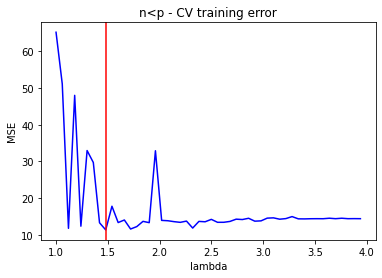

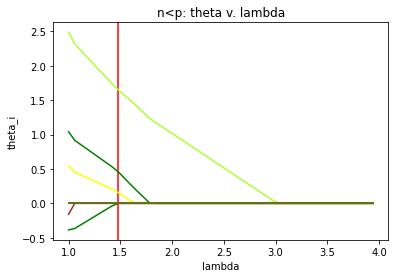

params selected: [1, 4, 8]
test error: 7.218156307382348
n=p CV error: 5.375994642973494 (lam=1.756)


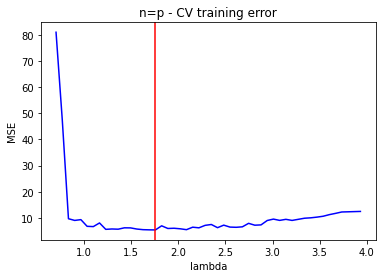

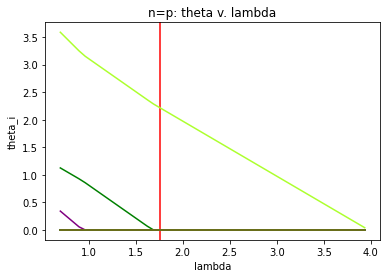

params selected: [8]
test error: 8.205600049812544
n>p CV error: 7.09161639683978 (lam=0.838)


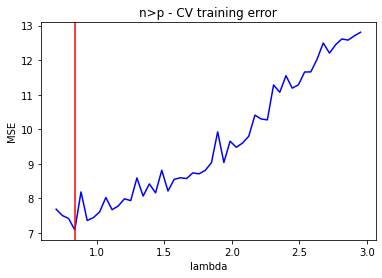

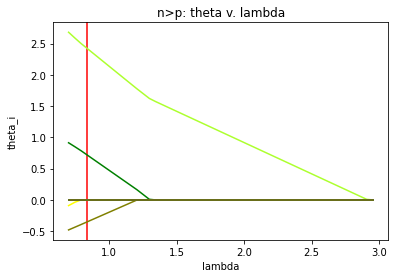

params selected: [1, 7, 8]
test error: 7.347932494569225


In [42]:
# LASSO
fname = 'ortho'
test_fn_lt(lasso_pathwise_cd, tuning_param_range(1, 4, 50), fname)
test_fn_eq(lasso_pathwise_cd, tuning_param_range(0.7, 4, 50), fname)
test_fn_gt(lasso_pathwise_cd, tuning_param_range(0.7, 3, 50), fname)

n<p CV error: 1.9266625090183453 (lam=0.962)


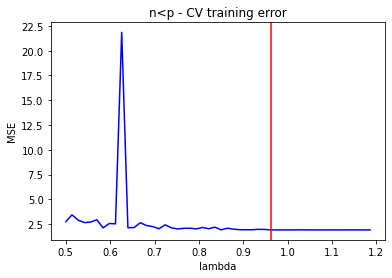

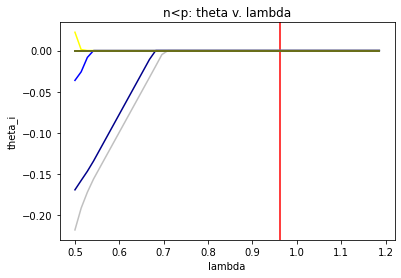

params selected: []
test error: 1.4160738183074826
n=p CV error: 1.0112681644334178 (lam=0.264)


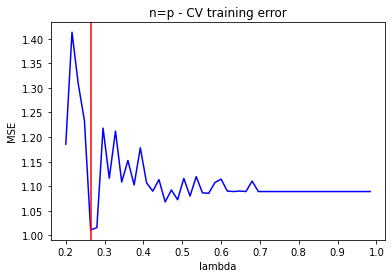

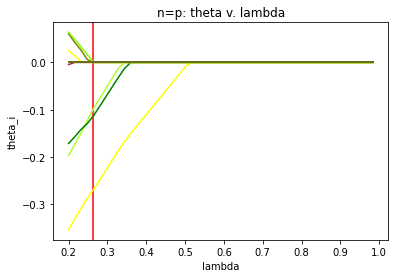

params selected: [14, 18, 21, 25]
test error: 1.5321562394350738
n>p CV error: 1.3042428681808445 (lam=0.334)


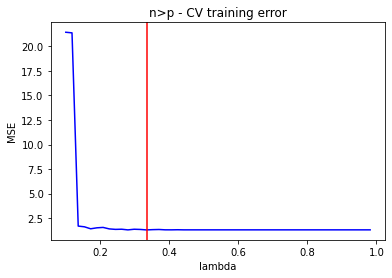

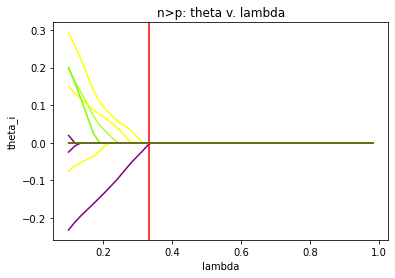

params selected: [3]
test error: 1.4160660460764922


In [43]:
# LASSO
fname = 'corr'
test_fn_lt(lasso_pathwise_cd, tuning_param_range(0.5, 1.2, 50), fname)
test_fn_eq(lasso_pathwise_cd, tuning_param_range(0.2, 1, 50), fname)
test_fn_gt(lasso_pathwise_cd, tuning_param_range(0.1, 1, 50), fname)

n<p CV error: 11.268002948781955 (lam=1.06)


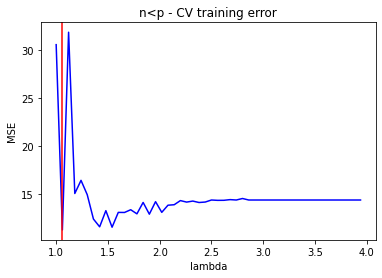

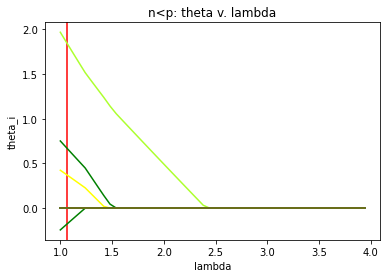

params selected: [1, 4, 8, 11]
test error: 7.079880200681896
n=p CV error: 5.338765655876978 (lam=1.3599999999999999)


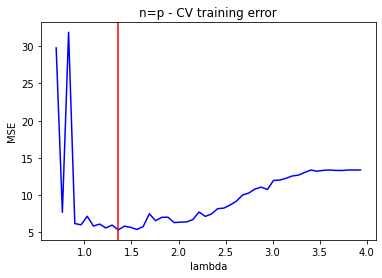

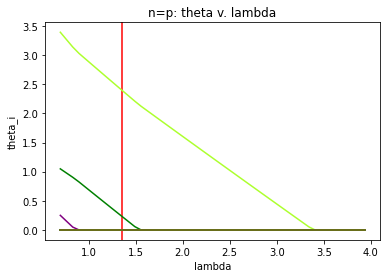

params selected: [1, 8]
test error: 7.844885140022174
n>p CV error: 7.208925217062908 (lam=0.9299999999999999)


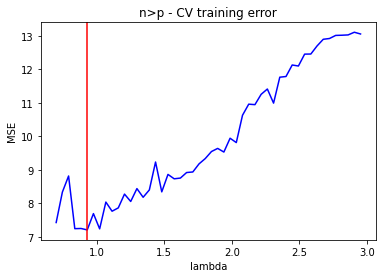

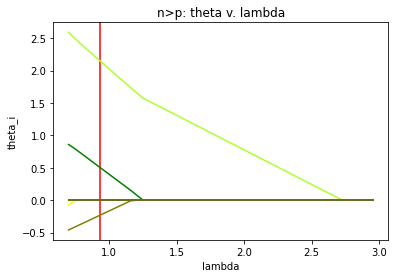

params selected: [1, 7, 8]
test error: 7.176750424642003


In [44]:
# Ridge w/ST
fname = 'ortho'
test_fn_lt(ridge_st_pathwise_cd, tuning_param_range(1, 4, 50), fname)
test_fn_eq(ridge_st_pathwise_cd, tuning_param_range(0.7, 4, 50), fname)
test_fn_gt(ridge_st_pathwise_cd, tuning_param_range(0.7, 3, 50), fname)

n<p CV error: 1.9266625090183453 (lam=0.8919999999999999)


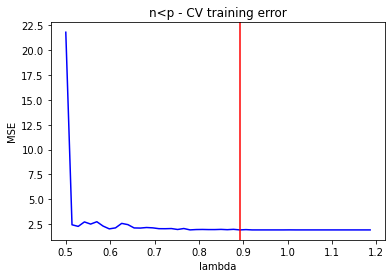

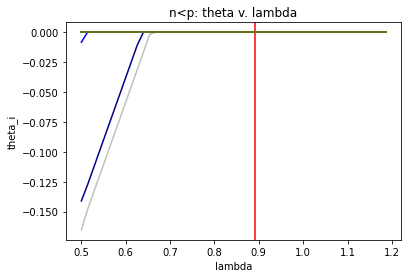

params selected: []
test error: 1.4160738183074826
n=p CV error: 1.0158229666883483 (lam=0.28)


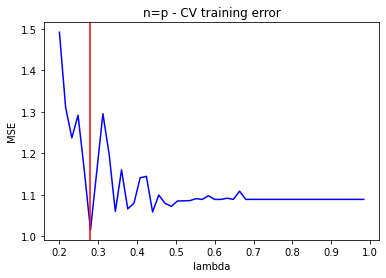

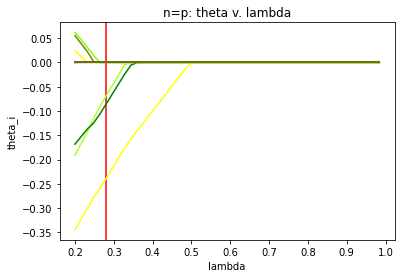

params selected: [14, 18, 21]
test error: 1.4999553543772113
n>p CV error: 1.2908435870120456 (lam=0.262)


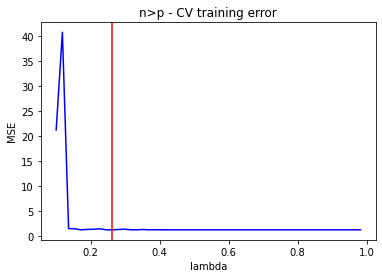

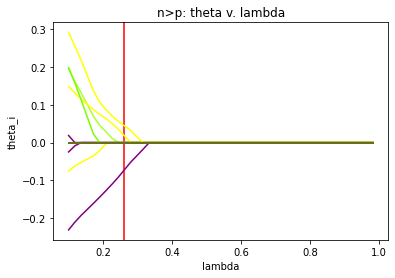

params selected: [3, 14, 24]
test error: 1.428218090701521


In [45]:
# Ridge w/ST
fname = 'corr'
test_fn_lt(ridge_st_pathwise_cd, tuning_param_range(0.5, 1.2, 50), fname)
test_fn_eq(ridge_st_pathwise_cd, tuning_param_range(0.2, 1, 50), fname)
test_fn_gt(ridge_st_pathwise_cd, tuning_param_range(0.1, 1, 50), fname)

n<p CV error: 13.018172016236113 (lam=1.24)


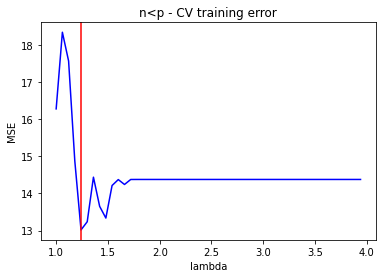

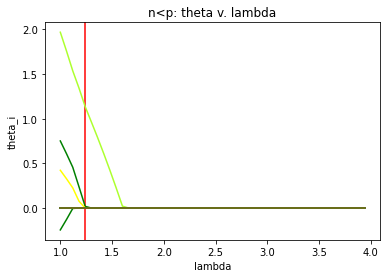

params selected: [1, 8]
test error: 8.802726933142381
n=p CV error: 5.322434291901843 (lam=1.0959999999999999)


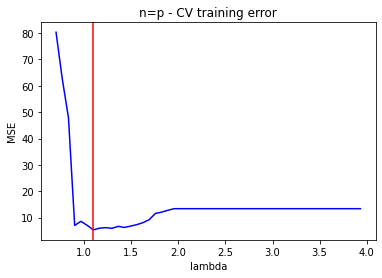

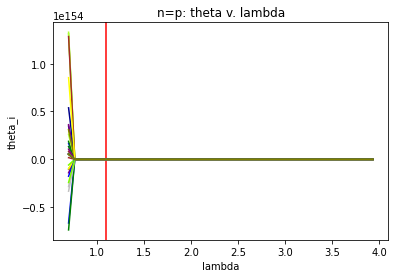

params selected: [1, 8]
test error: 7.847848970557611
n>p CV error: 7.25262454726182 (lam=0.976)


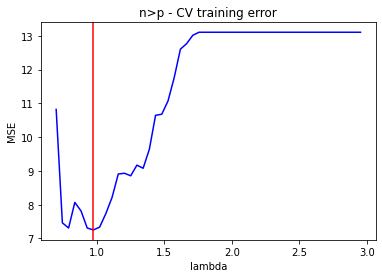

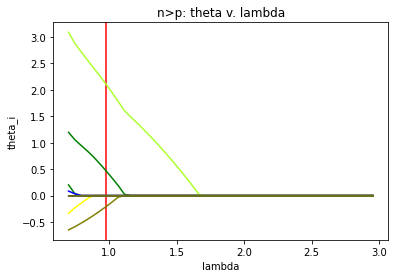

params selected: [1, 7, 8]
test error: 7.184188030187201


In [46]:
# Ridge w/Q ST
fname = 'ortho'
test_fn_lt(ridge_st_quad_pathwise_cd, tuning_param_range(1, 4, 50), fname)
test_fn_eq(ridge_st_quad_pathwise_cd, tuning_param_range(0.7, 4, 50), fname)
test_fn_gt(ridge_st_quad_pathwise_cd, tuning_param_range(0.7, 3, 50), fname)

n<p CV error: 1.9266625090183453 (lam=0.9199999999999999)


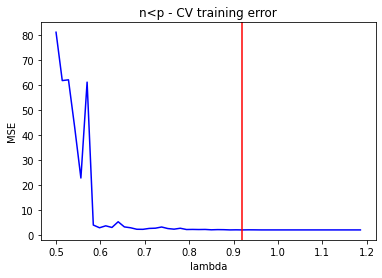

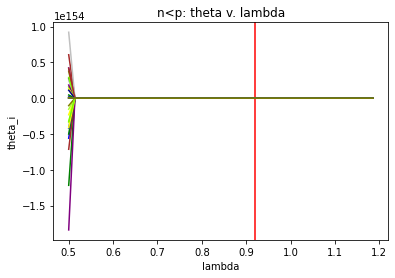

params selected: []
test error: 1.4160738183074826
n=p CV error: 1.0650743321009268 (lam=0.6160000000000001)


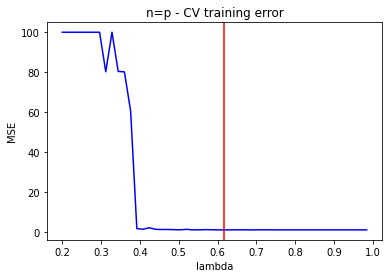

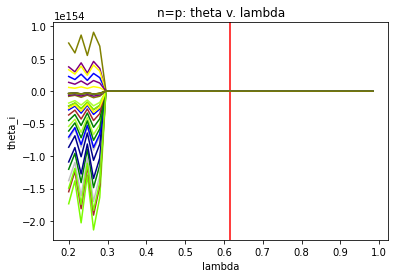

params selected: [14]
test error: 1.4290322199339287
n>p CV error: 1.2690039974373624 (lam=0.44200000000000006)


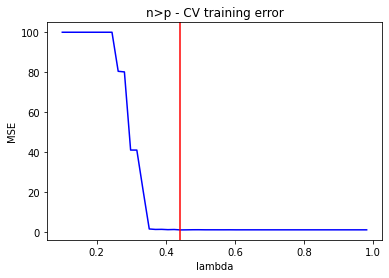

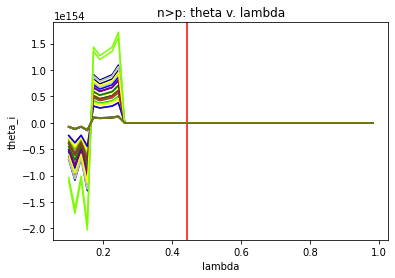

params selected: [3, 4, 8, 14, 24]
test error: 1.4734135997400286


In [47]:
# Ridge w/Q ST
fname = 'corr'
test_fn_lt(ridge_st_quad_pathwise_cd, tuning_param_range(0.5, 1.2, 50), fname)
test_fn_eq(ridge_st_quad_pathwise_cd, tuning_param_range(0.2, 1, 50), fname)
test_fn_gt(ridge_st_quad_pathwise_cd, tuning_param_range(0.1, 1, 50), fname)

n<p CV error: 11.89593678405468 (lam=1.06)


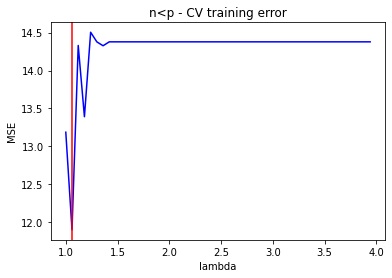

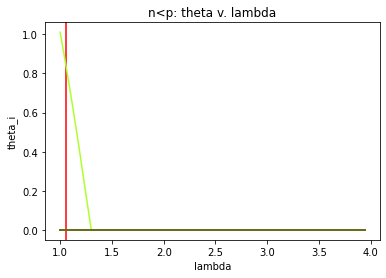

params selected: [8]
test error: 9.644552975895628
n=p CV error: 4.807000054751315 (lam=0.766)


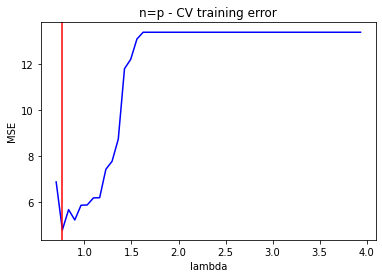

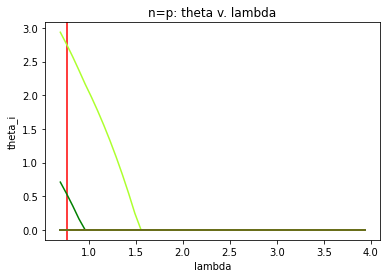

params selected: [1, 8]
test error: 7.987488442530885
n>p CV error: 7.6936928725474 (lam=0.746)


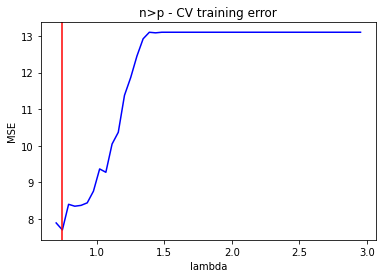

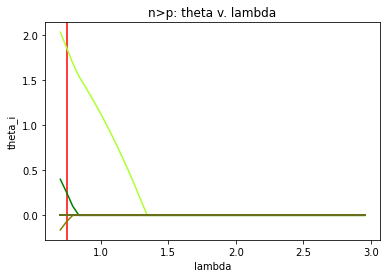

params selected: [1, 7, 8]
test error: 7.441192019681989


In [48]:
# Ridge w/Exp ST
fname = 'ortho'
test_fn_lt(ridge_st_exp_pathwise_cd, tuning_param_range(1, 4, 50), fname)
test_fn_eq(ridge_st_exp_pathwise_cd, tuning_param_range(0.7, 4, 50), fname)
test_fn_gt(ridge_st_exp_pathwise_cd, tuning_param_range(0.7, 3, 50), fname)

n<p CV error: 1.9266625090183453 (lam=0.6819999999999999)


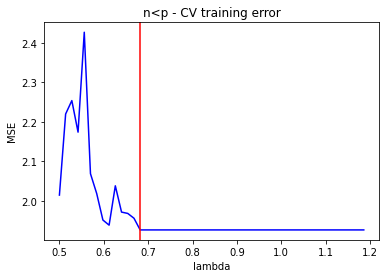

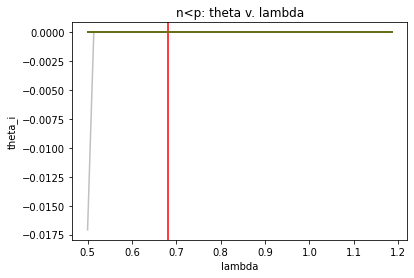

params selected: []
test error: 1.4160738183074826
n=p CV error: 1.0275730126808031 (lam=0.31200000000000006)


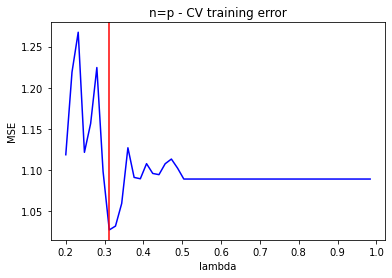

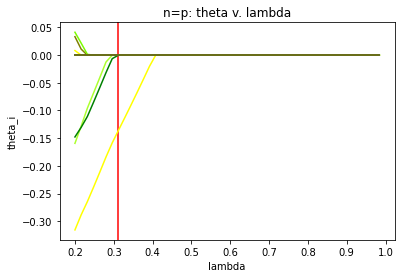

params selected: [14]
test error: 1.4354326964192399
n>p CV error: 1.3107237739219442 (lam=0.388)


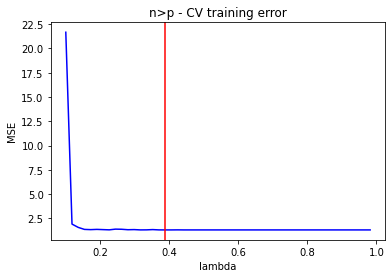

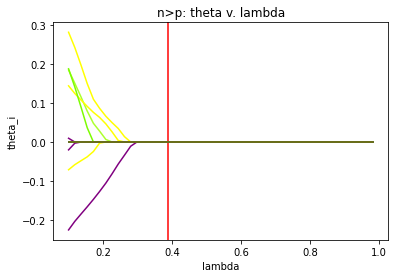

params selected: []
test error: 1.4160738183074826


In [49]:
# Ridge w/Exp ST
fname = 'corr'
test_fn_lt(ridge_st_exp_pathwise_cd, tuning_param_range(0.5, 1.2, 50), fname)
test_fn_eq(ridge_st_exp_pathwise_cd, tuning_param_range(0.2, 1, 50), fname)
test_fn_gt(ridge_st_exp_pathwise_cd, tuning_param_range(0.1, 1, 50), fname)

elastic net CV error: 12.217233273558842 (lam=3.0,alpha=0.4)


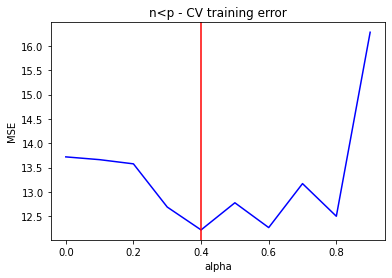

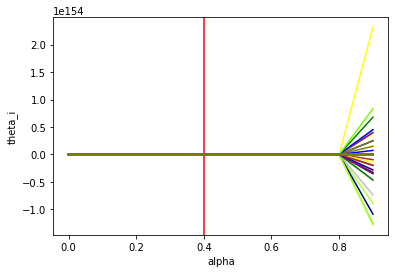

params selected: [8]
test error: 9.495145341090655
elastic net CV error: 4.601332710351868 (lam=4.6,alpha=0.8)


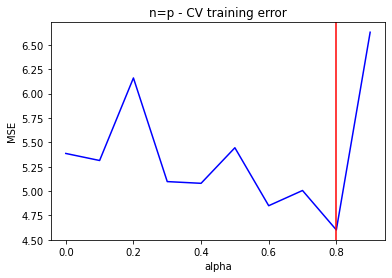

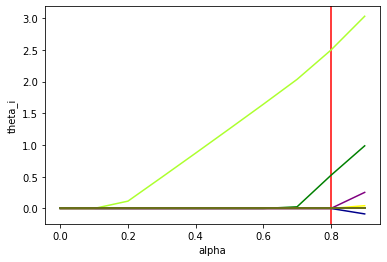

params selected: [1, 8]
test error: 7.4789582644839525
elastic net CV error: 6.642628494436083 (lam=3.0,alpha=0.8)


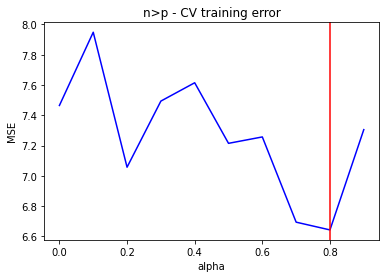

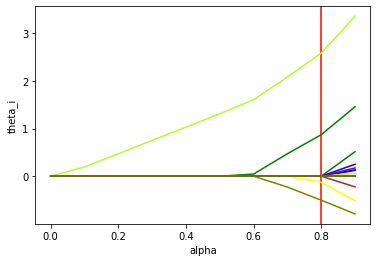

params selected: [1, 4, 7, 8]
test error: 7.781175508486528


In [53]:
# Elastic Net
fname = 'ortho'
test_fn_lt_en(elastic_net_pathwise_cd, tuning_param_range(0, 1, 10), tuning_param_range(1, 5, 10), fname)
test_fn_eq_en(elastic_net_pathwise_cd, tuning_param_range(0, 1, 10), tuning_param_range(1, 5, 10), fname)
test_fn_gt_en(elastic_net_pathwise_cd, tuning_param_range(0, 1, 10), tuning_param_range(1, 5, 10), fname)

elastic net CV error: 1.9266625090183453 (lam=1.4,alpha=0.0)


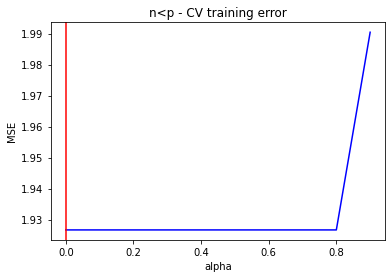

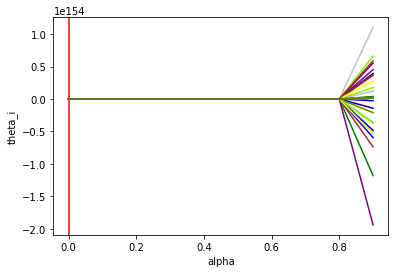

params selected: []
test error: 1.4160738183074826
elastic net CV error: 1.0234769819032052 (lam=1.8,alpha=0.9)


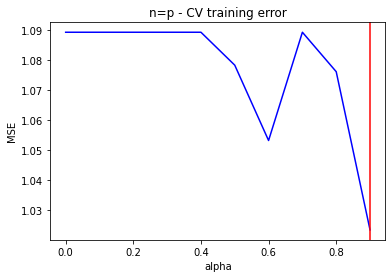

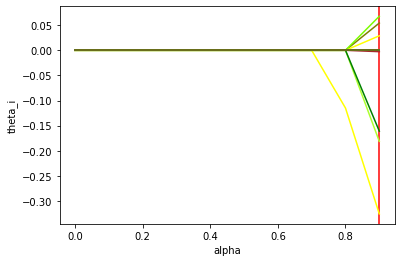

params selected: [2, 7, 14, 18, 21, 24, 25]
test error: 1.6433790438502822
elastic net CV error: 1.3027029115677597 (lam=1.0,alpha=0.7)


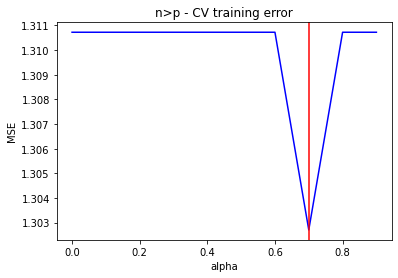

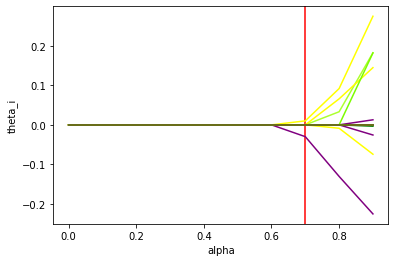

params selected: [3, 24]
test error: 1.4175092033116798


In [54]:
# Elastic Net
fname = 'corr'
test_fn_lt_en(elastic_net_pathwise_cd, tuning_param_range(0, 1, 10), tuning_param_range(1, 5, 10), fname)
test_fn_eq_en(elastic_net_pathwise_cd, tuning_param_range(0, 1, 10), tuning_param_range(1, 5, 10), fname)
test_fn_gt_en(elastic_net_pathwise_cd, tuning_param_range(0, 1, 10), tuning_param_range(1, 5, 10), fname)

n<p CV error: 12.22141402920315 (lam=1.16)


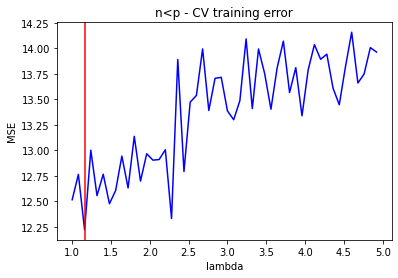

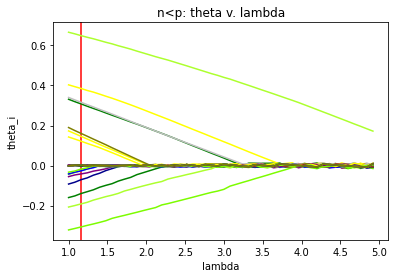

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: 10.357946358945773
n=p CV error: 6.443097458137994 (lam=1.4)


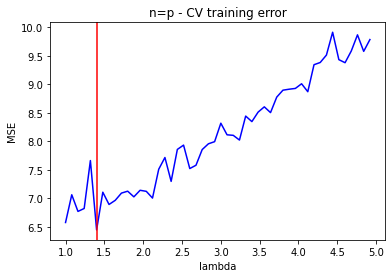

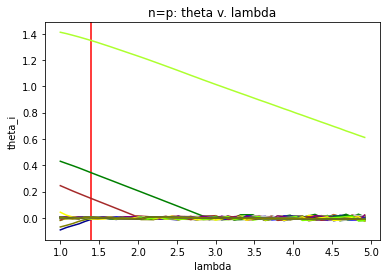

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: 7.757728526653304
n>p CV error: 7.492824604201336 (lam=1.08)


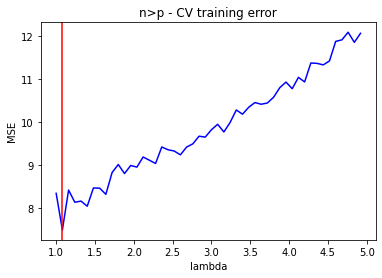

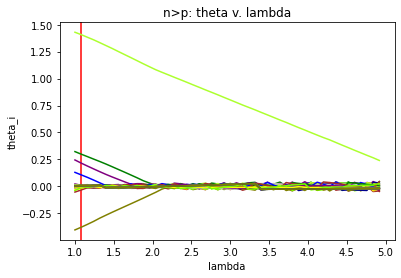

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: 7.953984495269351


In [55]:
# LASSO BGD
fname = 'ortho'
test_fn_lt(lasso_batch_gd, tuning_param_range(1, 5, 50), fname)
test_fn_eq(lasso_batch_gd, tuning_param_range(1, 5, 50), fname)
test_fn_gt(lasso_batch_gd, tuning_param_range(1, 5, 50), fname)

n<p CV error: 1.9236182335708236 (lam=1.952)


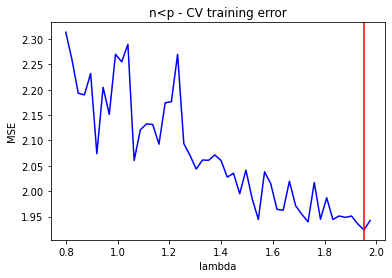

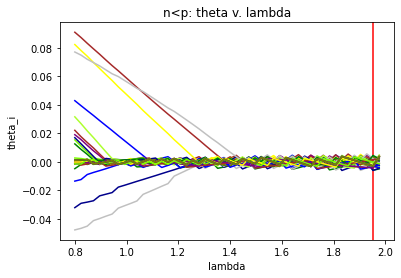

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: 1.416620392319675
n=p CV error: 1.0762975997326247 (lam=1.8800000000000001)


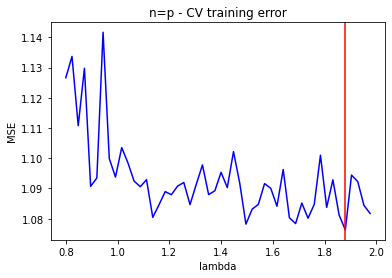

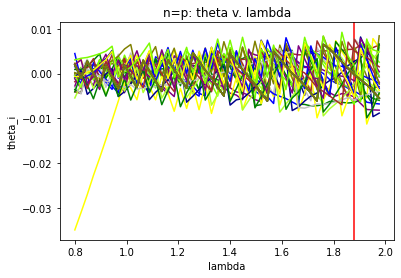

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: 1.418113588695107
n>p CV error: 1.292746498278167 (lam=1.928)


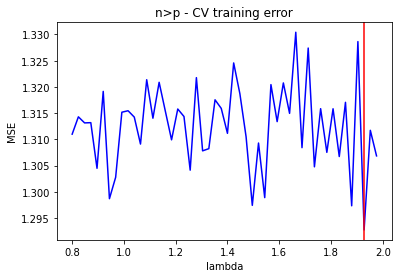

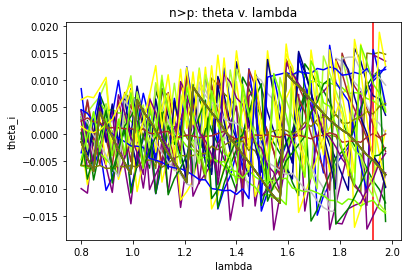

params selected: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
test error: 1.4194471855500905


In [56]:
# LASSO BGD
fname = 'corr'
test_fn_lt(lasso_batch_gd, tuning_param_range(0.8, 2, 50), fname)
test_fn_eq(lasso_batch_gd, tuning_param_range(0.8, 2, 50), fname)
test_fn_gt(lasso_batch_gd, tuning_param_range(0.8, 2, 50), fname)